<table style="width: 100%; border: none;">
  <tr style="border: none;">
    <td style="width: 15%; border: none; vertical-align: middle;">
      <img src="https://th.bing.com/th/id/OIP.zZshkvEYWRVv1orlaBMmjwHaHa?w=155&h=180&c=7&r=0&o=5&pid=1.7" alt="Logo UNALM" style="width: 100px;">
    </td>
    <td style="width: 85%; border: none; vertical-align: middle; text-align: left;">
      <h2 style="margin: 0; color: #1a4d2e;">UNIVERSIDAD NACIONAL AGRARIA LA MOLINA</h2>
      <h4 style="margin: 2px 0; color: #444;">FACULTAD DE ECONOMÍA Y PLANIFICACIÓN</h4>
      <h5 style="margin: 0; color: #666; font-weight: normal;">DEPARTAMENTO DE ESTADÍSTICA E INFORMÁTICA</h5>
    </td>
  </tr>
</table>

<hr style="border-top: 2px solid #1a4d2e; margin: 10px 0;">

<div style="padding: 10px;">
  <p style="font-size: 16px; margin: 5px 0;">
    <strong>Curso:</strong> LENGUAJE DE PROGRAMACIÓN II <br>
    <strong>Docente:</strong> Denisse Chalan
  </p>

  <h4 style="margin-top: 15px; color: #1a4d2e;">Integrantes:</h4>
  <ul style="line-height: 1.6;">
    <li>Ormeño Sakihama, Daniel Kenyi - (20240723)</li>
    <li>Garay Ramos, Jose Luis - (20230678)</li>
    <li>Apellido Paterno, Nombre - (Código)</li>
    <li>Apellido Paterno, Nombre - (Código)</li>
  </ul>
</div>

## 1. Introducción a la API de Datos Abiertos del Banco Mundial

La herramienta seleccionada para la extracción de datos en este proyecto es la **API (Interfaz de Programación de Aplicaciones) de Indicadores del Banco Mundial** (*World Bank Open Data API*).

Esta interfaz es fundamental para el análisis debido a sus características principales:

* **Robustez y Confiabilidad:** Es considerada una de las fuentes más sólidas a nivel global.
* **Accesibilidad:** Provee acceso programático directo a bases de datos oficiales.
* **Cobertura Multidisciplinaria:** Permite la obtención de información estadística vital sobre **desarrollo económico, demografía, salud y medio ambiente**.

## 2. Análisis descriptivo de Datos (API Banco Mundial)

En esta etapa, utilizaremos **Python** para extraer información actualizada directamente de los servidores del Banco Mundial.

**Objetivo del Script:**
El propósito de este bloque de código no es solo visualizar una tabla, sino **construir y estructurar el conjunto de datos (DataFrame)** que servirá como base para la **generación de gráficos estadísticos** en la siguiente sección.

**El proceso consta de:**
1.  **Conexión:** Petición de datos macroeconómicos (PBI, Inflación, Gini, etc.) para 12 países de Sudamérica.
2.  **Limpieza:** Filtrado del año más reciente disponible (entre 2019-2024) para garantizar la actualidad del análisis.
3.  **Previsualización:** Muestra de un resumen tabular estilizado para validar que los datos se han cargado correctamente antes de graficar.

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# PASO 1: DESCARGA REAL DESDE LA API (ETL)
# ==============================================================================
print("📡 Conectando al Banco Mundial...", end="")

paises_sudamerica = ['ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN']
codigos_paises = ';'.join(paises_sudamerica)

indicadores = {
    'NY.GDP.MKTP.CD': 'PBI_Raw',
    'SP.POP.TOTL':    'Poblacion_Raw',
    'SI.POV.NAHC':    'Pobreza_Nacional',
    'FP.CPI.TOTL.ZG': 'Inflacion_Anual',
    'SI.POV.GINI':    'Indice_Gini'
}

def descargar_wb(indicador, paises):
    # Pedimos datos desde 2015 para asegurar que si no hay dato 2024, tome el de 2023 o 2022
    url = f"http://api.worldbank.org/v2/country/{paises}/indicator/{indicador}?format=json&date=2015:2024&per_page=1000"
    try:
        data = requests.get(url).json()
        if len(data) < 2: return []
        lista = []
        for item in data[1]:
            if item['value'] is not None:
                lista.append({
                    'Codigo_ISO': item['countryiso3code'],
                    'País': item['country']['value'],
                    'Año': item['date'],
                    'Valor': item['value']
                })
        return lista
    except:
        return []

dfs = []
for codigo_api, nombre_interno in indicadores.items():
    datos = descargar_wb(codigo_api, codigos_paises)
    if datos:
        temp = pd.DataFrame(datos)
        # TRUCO PRO: Ordenamos por año y nos quedamos con el PRIMERO (el más reciente)
        temp = temp.sort_values('Año', ascending=False).drop_duplicates('Codigo_ISO')
        temp = temp[['País', 'Valor']].rename(columns={'Valor': nombre_interno})
        temp = temp.set_index('País')
        dfs.append(temp)
    print(".", end="")

# Unimos todo en un solo DataFrame
if dfs:
    df = pd.concat(dfs, axis=1)

    # --- TRANSFORMACIÓN DE UNIDADES (Para que coincida con tus gráficos) ---
    # Tus gráficos piden 'PBI_Billions' y 'Poblacion_Millones'
    if 'PBI_Raw' in df.columns:
        df['PBI_Billions'] = df['PBI_Raw'] / 1e9  # Convertimos a Miles de Millones

    if 'Poblacion_Raw' in df.columns:
        df['Poblacion_Millones'] = df['Poblacion_Raw'] / 1e6 # Convertimos a Millones

    print("\n✅ Datos descargados y procesados correctamente.\n")
    # Mostramos las primeras filas para verificar
    display(df.head(3))
else:
    print("\n❌ Error crítico: La API no devolvió datos. Revisa tu conexión.")

📡 Conectando al Banco Mundial........
✅ Datos descargados y procesados correctamente.



,PBI_Raw,Poblacion_Raw,Pobreza_Nacional,Inflacion_Anual,Indice_Gini,PBI_Billions,Poblacion_Millones
País,,,,,,,
Argentina,6.383655e+11,45696159,38.1,219.883929,42.4,638.365455,45.696159
Brazil,2.185822e+12,211998573,NaN,4.367464,51.6,2185.821649,211.998573
"Venezuela, RB",1.198030e+11,28405543,33.1,254.948535,NaN,119.802963,28.405543


### 2.1 Mapa de Calor: El "Termómetro" de la Inflación

Este gráfico funciona como una alerta visual para identificar la estabilidad monetaria en la región.
* **Colores Rojos Intensos:** Indican economías con **alta inflación**. En estos países, los precios suben rápidamente, lo que erosiona el poder adquisitivo de las personas.
* **Colores Claros:** Indican **estabilidad**. El dinero mantiene su valor en el tiempo.

**Conclusión:** Podemos identificar rápidamente los focos de riesgo económico en Sudamérica y contrastarlos con los países que mantienen políticas monetarias estables.

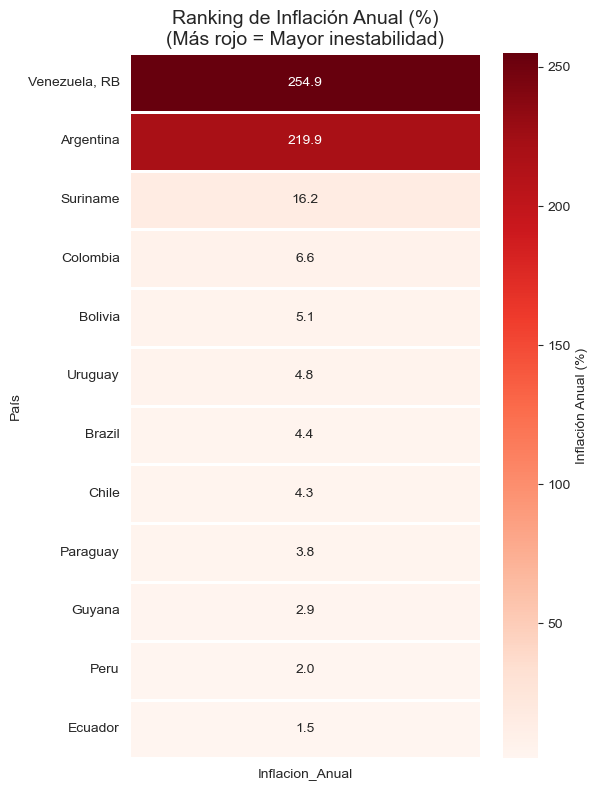

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de Estilo General
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Aseguramos que el DataFrame 'df' tenga el índice correcto si no lo tiene
if 'País' in df.columns:
    df = df.set_index('País')

# Filtramos y ordenamos
if 'Inflacion_Anual' in df.columns:
    df_inflacion = df[['Inflacion_Anual']].sort_values(by='Inflacion_Anual', ascending=False)

    plt.figure(figsize=(6, 8))

    sns.heatmap(df_inflacion,
                annot=True,            # Muestra el número
                cmap='Reds',           # Rojo = Peligro
                fmt=".1f",             # 1 decimal
                cbar_kws={'label': 'Inflación Anual (%)'},
                linewidths=1, linecolor='white') # Bordes para limpieza visual

    plt.title('Ranking de Inflación Anual (%)\n(Más rojo = Mayor inestabilidad)', fontsize=14)
    plt.tight_layout()
    plt.show()

### 2.2 Desigualdad Social (Índice Gini)

El PBI nos dice cuánto dinero tiene un país, pero el **Índice Gini** nos dice cómo se reparte ese dinero.
* **Barras más largas (Cercanas a 100):** Indican mayor desigualdad. La brecha entre ricos y pobres es muy amplia.
* **Barras más cortas (Cercanas a 0):** Indican una distribución de riqueza más equitativa.

**Análisis:** Este ranking nos permite ver qué países, independientemente de su riqueza total, han logrado construir sociedades más justas en términos económicos.

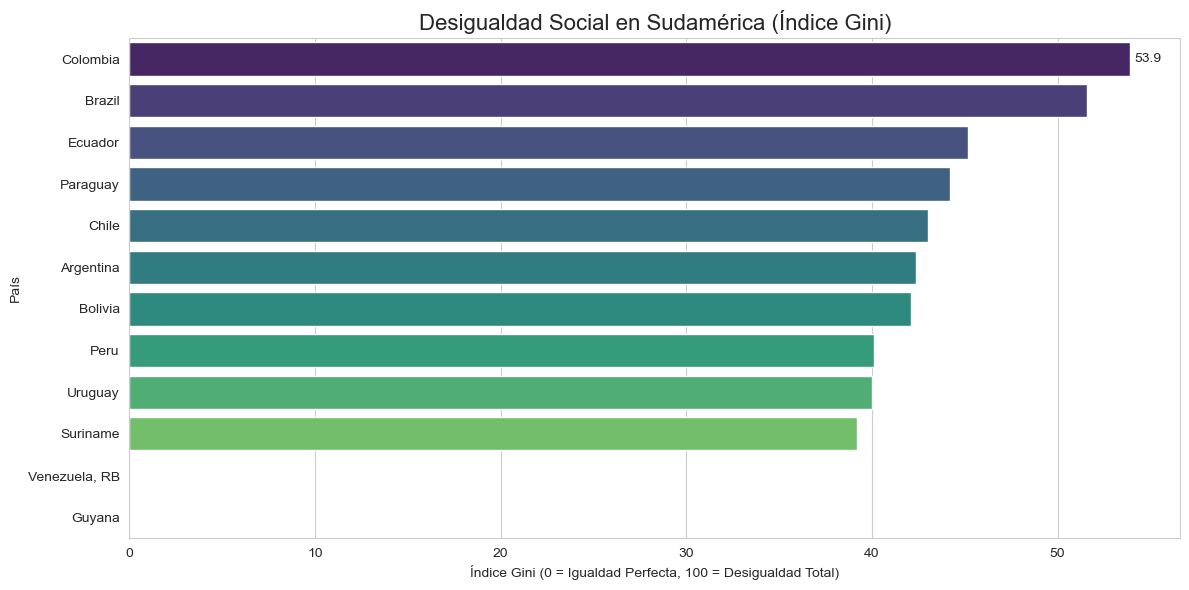

In [ ]:
# ==============================================================================
# GRÁFICO 2 CORREGIDO: RANKING DE DESIGUALDAD (GINI)
# ==============================================================================
if 'Indice_Gini' in df.columns:
    # Ordenamos de mayor a menor desigualdad
    df_gini = df.sort_values('Indice_Gini', ascending=False)

    plt.figure(figsize=(12, 6))

    # --- CORRECCIÓN AQUÍ ---
    # Antes: palette='viridis'
    # Ahora: hue=df_gini.index, palette='viridis', legend=False
    grafico = sns.barplot(
        x=df_gini['Indice_Gini'],
        y=df_gini.index,
        hue=df_gini.index,     # Asignamos el color al País
        palette='viridis',
        legend=False           # Ocultamos la leyenda
    )

    plt.title('Desigualdad Social en Sudamérica (Índice Gini)', fontsize=16)
    plt.xlabel('Índice Gini (0 = Igualdad Perfecta, 100 = Desigualdad Total)')

    # Agregamos los valores al final de las barras
    plt.bar_label(grafico.containers[0], fmt='%.1f', padding=3)

    plt.tight_layout()
    plt.show()

### 2.3 Correlación: Inflación vs. Pobreza

Este gráfico de dispersión busca responder: **¿La subida de precios genera más pobreza?**
Dividimos el gráfico en cuadrantes usando el promedio regional (líneas punteadas):
1.  **Cuadrante Superior Derecho:** Países con el "doble castigo" (Alta Inflación y Alta Pobreza). Son los casos más críticos.
2.  **Cuadrante Inferior Izquierdo:** El escenario ideal (Baja Inflación y Baja Pobreza).

**Interpretación:** La ubicación de los puntos nos ayuda a entender si la inestabilidad de precios está golpeando a los sectores más vulnerables de cada país.

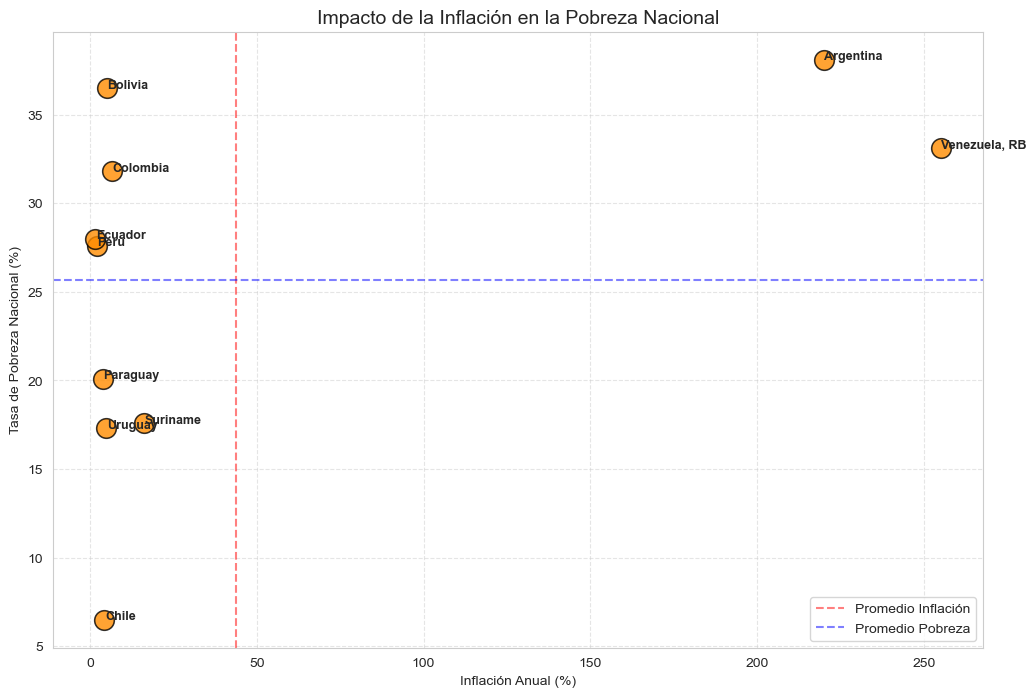

In [ ]:
if 'Inflacion_Anual' in df.columns and 'Pobreza_Nacional' in df.columns:
    plt.figure(figsize=(12, 8))

    # Gráfico de dispersión
    sns.scatterplot(data=df, x='Inflacion_Anual', y='Pobreza_Nacional',
                    s=200, color='darkorange', alpha=0.8, edgecolor='black')

    # Nombres de los países
    for pais in df.index:
        plt.text(df.loc[pais, 'Inflacion_Anual']+0.2,
                 df.loc[pais, 'Pobreza_Nacional'],
                 pais, fontsize=9, fontweight='bold')

    # Líneas promedio (Cuadrantes)
    plt.axvline(x=df['Inflacion_Anual'].mean(), color='red', linestyle='--', alpha=0.5, label='Promedio Inflación')
    plt.axhline(y=df['Pobreza_Nacional'].mean(), color='blue', linestyle='--', alpha=0.5, label='Promedio Pobreza')
    plt.legend()

    plt.title('Impacto de la Inflación en la Pobreza Nacional', fontsize=14)
    plt.xlabel('Inflación Anual (%)')
    plt.ylabel('Tasa de Pobreza Nacional (%)')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

### 2.4 Riqueza Promedio por Habitante (PBI Per Cápita)

Este indicador elimina el "efecto tamaño". Brasil tiene una economía gigante porque tiene mucha población, pero eso no significa que el ciudadano promedio sea rico.
* **El cálculo:** Dividimos el PBI Total entre la Población Total.
* **El resultado:** Obtenemos una aproximación del ingreso promedio anual por persona en dólares.

**Conclusión:** Este ranking refleja mejor la **calidad de vida y poder de consumo** promedio. Vemos cómo países pequeños pueden superar a economías grandes cuando ajustamos por población.

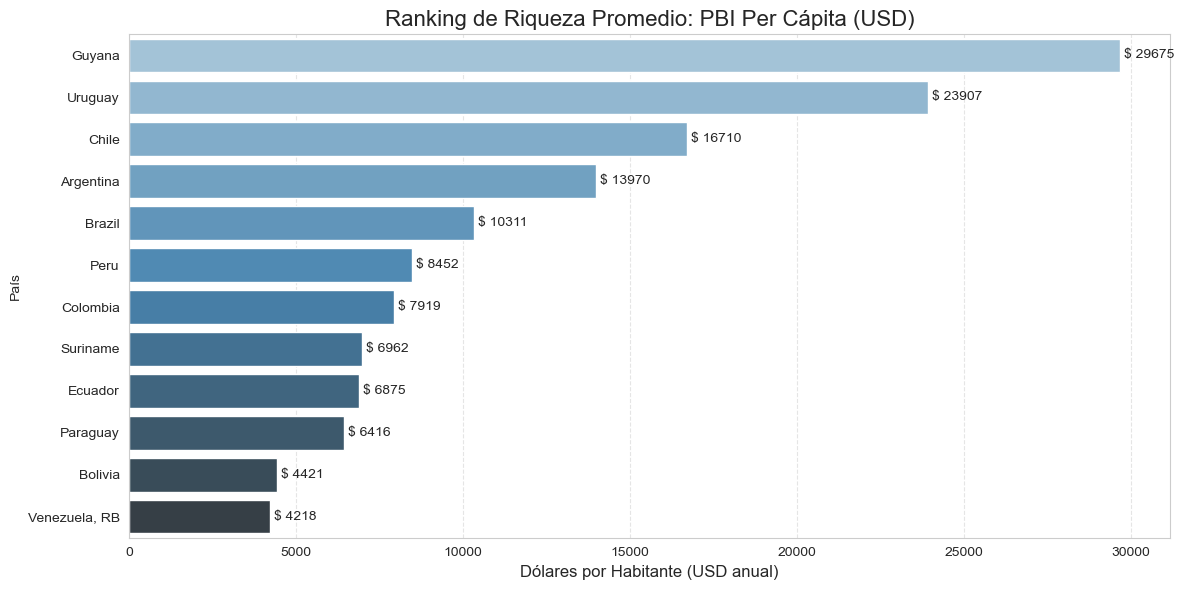

In [ ]:
# ==============================================================================
# GRÁFICO 4: RIQUEZA REAL POR HABITANTE (PBI PER CÁPITA)
# ==============================================================================
if 'PBI_Billions' in df.columns and 'Poblacion_Millones' in df.columns:
    # 1. Cálculos
    df['PBI_Per_Capita'] = (df['PBI_Billions'] / df['Poblacion_Millones']) * 1000
    df_per_capita = df.sort_values('PBI_Per_Capita', ascending=False)

    plt.figure(figsize=(12, 6))

    # --- CORRECCIÓN AQUÍ ---
    # Antes: palette='Blues_d'
    # Ahora: hue=df_per_capita.index, palette='Blues_d', legend=False
    grafico = sns.barplot(
        x=df_per_capita['PBI_Per_Capita'],
        y=df_per_capita.index,
        hue=df_per_capita.index,  # Asignamos el color al País
        palette='Blues_d',
        legend=False              # Ocultamos la leyenda porque ya tenemos etiquetas en el eje Y
    )

    plt.title('Ranking de Riqueza Promedio: PBI Per Cápita (USD)', fontsize=16)
    plt.xlabel('Dólares por Habitante (USD anual)', fontsize=12)

    # Etiquetas de datos ($)
    for i, container in enumerate(grafico.containers):
        grafico.bar_label(container, fmt='$ %.0f', padding=3)

    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

### 2.5 Evolución del PBI del Perú y Predicción Económica

A diferencia del análisis comparativo regional presentado anteriormente, en esta sección se realiza un análisis específico del **Producto Bruto Interno (PBI) real del Perú**, utilizando datos oficiales obtenidos a través de la **API Data360 del Banco Mundial**.

* **Enfoque:** Análisis temporal del crecimiento económico del Perú.
* **Fuente de datos:** API Data360 – Banco Mundial.
* **Metodología:** Limpieza de datos, visualización y modelamiento estadístico.

**Interpretación:**  
La evolución histórica del PBI muestra una tendencia de crecimiento a largo plazo, con periodos de desaceleración y recuperación económica asociados a eventos coyunturales relevantes.

**Predicción:**  
Mediante el uso de regresión polinómica, se realiza una estimación del PBI para el año 2025 con fines estrictamente académicos.

**Conclusión:**  
Este análisis permite complementar el estudio regional incorporando un caso nacional específico, demostrando la aplicación de técnicas de programación y análisis estadístico para el estudio del crecimiento económico.



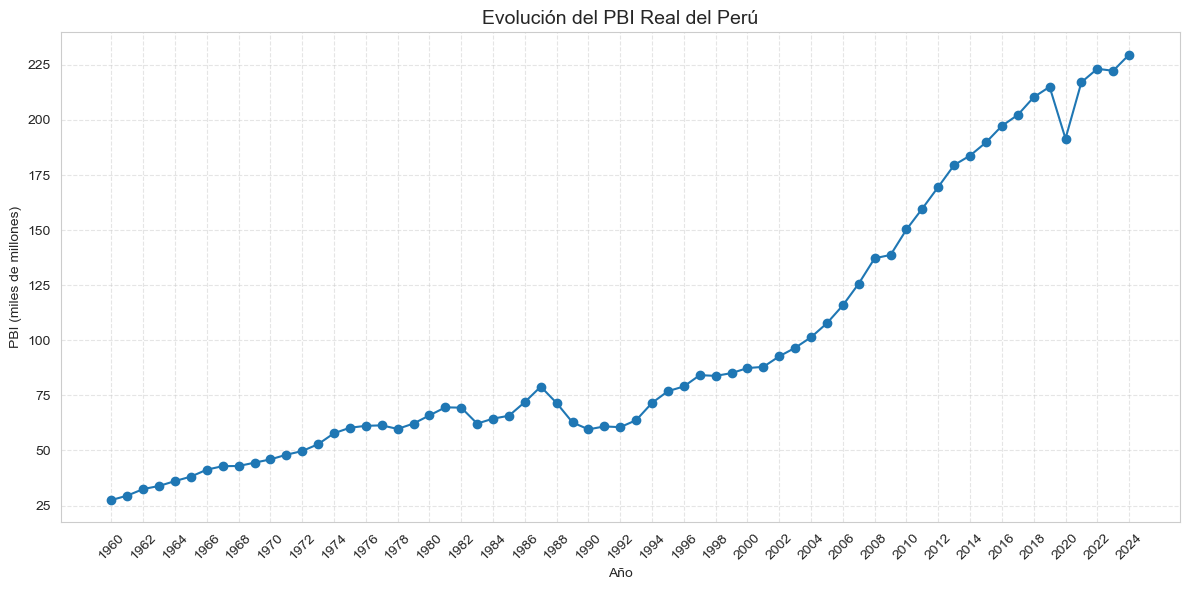

In [ ]:
import matplotlib.pyplot as plt
import requests
import pandas as pd

url = "https://data360api.worldbank.org/data360/data"

parametros = {
    "DATABASE_ID": "WB_WDI",
    "REF_AREA": "PER",
    "INDICATOR": "WB_WDI_NY_GDP_MKTP_KD"
}

response = requests.get(url, params=parametros)
json_data = response.json()

df_pbi = pd.DataFrame(json_data['value'])
df_pbi['OBS_VALUE'] = pd.to_numeric(df_pbi['OBS_VALUE'], errors='coerce')
df_pbi = df_pbi.dropna(subset=['OBS_VALUE'])

# Convertimos a miles de millones
df_pbi['PBI_miles_millones'] = df_pbi['OBS_VALUE'] / 1e9

plt.figure(figsize=(12, 6))

plt.plot(
    df_pbi['TIME_PERIOD'],
    df_pbi['PBI_miles_millones'],
    marker='o'
)

plt.title('Evolución del PBI Real del Perú', fontsize=14)
plt.xlabel('Año')
plt.ylabel('PBI (miles de millones)')
plt.grid(True, linestyle='--', alpha=0.5)

# 🔹 MOSTRAR ETIQUETAS CADA 2 AÑOS
plt.xticks(
    ticks=df_pbi['TIME_PERIOD'][::2],
    rotation=45
)

plt.tight_layout()
plt.show()


# 2.6 Análisis Comparativo Regional

Para contextualizar la situación de Perú, es necesario realizar un análisis comparativo con otras economías de la región (Latinoamérica). En esta sección utilizaremos la API del Banco Mundial para responder tres preguntas clave mediante visualización de datos:

1.  **Ranking (2022):** ¿Qué posición ocupa Perú en términos de tamaño de economía frente a sus vecinos?
2.  **Volatilidad (2010-2023):** ¿Qué tan estable ha sido el crecimiento económico comparado con la Alianza del Pacífico?
3.  **Correlación:** ¿Existe una relación directa entre la riqueza de un país (PBI) y la calidad de vida (Esperanza de Vida)?

## Persistencia y enriquecimiento de los datos

In [ ]:
# ==============================================================================
# MÓDULO DE PERSISTENCIA: GUARDANDO RESULTADOS
# ==============================================================================
import json

# 1. Guardar en CSV (Ideal para compartir con analistas en Excel)
# Usamos index=False para no guardar el índice numérico (0, 1, 2...)
# encoding='utf-8-sig' es vital para que Excel lea bien las tildes (Perú)
nombre_archivo_csv = 'reporte_pbi_banco_mundial.csv'
df_pbi.to_csv(nombre_archivo_csv, index=False, encoding='utf-8-sig')
print(f"✅ Archivo CSV generado: {nombre_archivo_csv}")

# 2. Guardar en JSON (Ideal para enviar datos a una Web o App)
# orient='records' crea una lista de objetos: [{"Año": 2020, "PBI":...}, ...]
json_str = df_pbi.to_json(orient='records', indent=4)

with open('reporte_pbi_banco_mundial.json', 'w', encoding='utf-8') as f:
    f.write(json_str)

print("✅ Archivo JSON generado: reporte_pbi_banco_mundial.json")

In [ ]:
# ==============================================================================
# MÓDULO DE SCRAPING: OBTENER CAPITALES DE WIKIPEDIA
# ==============================================================================
import requests
from bs4 import BeautifulSoup

def obtener_capital_wikipedia(pais_busqueda):
    """
    Busca la capital de un país directamente en su ficha de Wikipedia.
    """
    # 1. Construimos la URL dinámicamente
    url = f"https://es.wikipedia.org/wiki/{pais_busqueda}"

    # 2. ÉTICA: User-Agent para identificarnos correctamente
    headers = {'User-Agent': 'EstudianteDatos_UNALM/1.0'}

    try:
        response = requests.get(url, headers=headers)
        if response.status_code == 200:
            sopa = BeautifulSoup(response.text, 'html.parser')

            # 3. Navegación del DOM: Buscamos la "Infobox" (tabla lateral derecha)
            # En Wikipedia en español, suele ser la clase "infobox geografia"
            tabla_info = sopa.find('table', {'class': 'infobox'})

            if tabla_info:
                # Buscamos filas que contengan la palabra "Capital"
                for fila in tabla_info.find_all('tr'):
                    header = fila.find('th')
                    if header and 'Capital' in header.text:
                        # Encontramos la celda de datos adjunta
                        dato = fila.find('td')
                        if dato:
                            # Limpiamos notas al pie como [1]
                            return dato.text.split('[')[0].strip()
        return "No encontrada"
    except Exception as e:
        return f"Error: {e}"

# --- Probamos el Scraping ---
pais_objetivo = "Perú"
capital_scrapeada = obtener_capital_wikipedia(pais_objetivo)

print(f"🌎 País: {pais_objetivo}")
print(f"🏛️ Capital extraída con BS4: {capital_scrapeada}")

# Agregamos esta info a tu DataFrame (como es solo 1 país en tu ejemplo actual)
df_pbi['Capital'] = capital_scrapeada
print("✅ Columna 'Capital' agregada al DataFrame.")

## **3. Análisis predictivos API Data Mundial**

### **Análisis de regresión**

Se estima un modelo de regresión lineal múltiple mediante Mínimos Cuadrados Ordinarios (OLS)
para analizar la relación entre la pobreza nacional y variables macroeconómicas seleccionadas.

#### **3.1 Evaluación de supuestos del modelo de regresión**

En esta sección se verifican los principales supuestos del modelo de regresión
lineal estimado previamente. Estos supuestos permiten evaluar si los resultados
del modelo son confiables y correctamente interpretables.

In [ ]:
# =====================================================
# Cálculo de los indicadores de los supuestos
# =====================================================

import numpy as np
import pandas as pd
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import jarque_bera

# Normalidad de los errores (Jarque-Bera)
jb_stat, jb_pvalue = jarque_bera(modelo.resid)

# Independencia de errores (Durbin-Watson)
dw = durbin_watson(modelo.resid)

# Multicolinealidad (Número de condición)
cond_number = modelo.condition_number

# Homocedasticidad (relación entre errores y valores ajustados)
corr_resid_fitted = np.corrcoef(
    modelo.fittedvalues,
    np.abs(modelo.resid)
)[0, 1]

#### **3.2 Indicadores utilizados**

- **Jarque-Bera:** evalúa si los errores del modelo siguen una distribución normal.
- **Durbin-Watson:** permite detectar autocorrelación entre los errores.
- **Número de condición:** indica si existe multicolinealidad entre las variables explicativas.
- **Correlación residuos-ajustados:** ayuda a evaluar la estabilidad de la varianza
  de los errores (homocedasticidad).

In [ ]:
# =====================================================
# Tabla resumen de supuestos del modelo
# =====================================================

tabla_supuestos = pd.DataFrame({
    "Supuesto": [
        "Normalidad de los errores",
        "Independencia de los errores",
        "Homocedasticidad",
        "Multicolinealidad"
    ],
    "Indicador": [
        "Jarque-Bera (p-valor)",
        "Durbin-Watson",
        "Corr(|residuos|, ajustados)",
        "Número de condición"
    ],
    "Valor": [
        round(jb_pvalue, 3),
        round(dw, 3),
        round(corr_resid_fitted, 3),
        f"{cond_number:.2e}"
    ],
    "Conclusión": [
        "Se cumple" if jb_pvalue > 0.05 else "No se cumple",
        "Se cumple" if 1.5 < dw < 2.5 else "Posible problema",
        "Se cumple" if abs(corr_resid_fitted) < 0.3 else "Posible heterocedasticidad",
        "Posible problema" if cond_number > 30 else "Sin problema"
    ]
})

tabla_supuestos


,Supuesto,Indicador,Valor,Conclusión
0,Normalidad de los errores,Jarque-Bera (p-valor),0.73,Se cumple
1,Independencia de los errores,Durbin-Watson,2.63,Posible problema
2,Homocedasticidad,"Corr(|residuos|, ajustados)",-0.625,Posible heterocedasticidad
3,Multicolinealidad,Número de condición,1.39e+05,Posible problema


#### **3.3 Interpretación de los supuestos**

La tabla anterior resume la evaluación de los supuestos del modelo.  
En general:

- Un **p-valor mayor a 0.05** en Jarque-Bera indica normalidad de los errores.
- Un **Durbin-Watson cercano a 2** sugiere independencia de los errores.
- Una **correlación pequeña** entre errores y valores ajustados indica homocedasticidad.
- Un **número de condición bajo** sugiere ausencia de multicolinealidad severa.

#### **3.4 Gráficos de diagnóstico**

<Figure size 800x600 with 0 Axes>

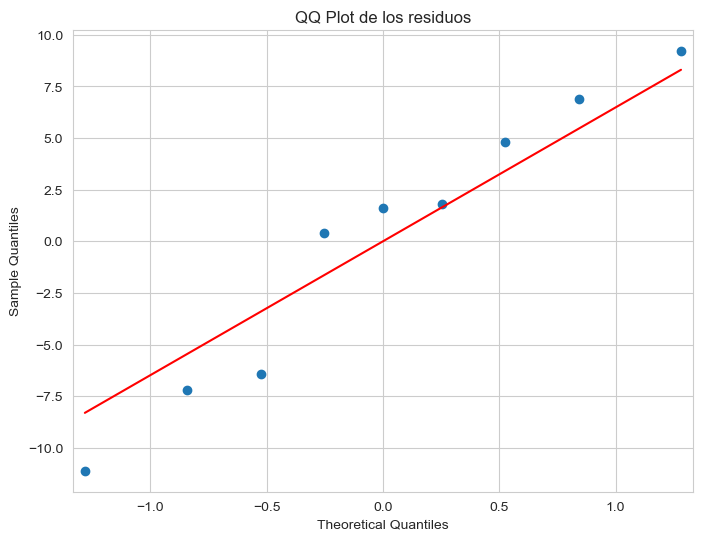

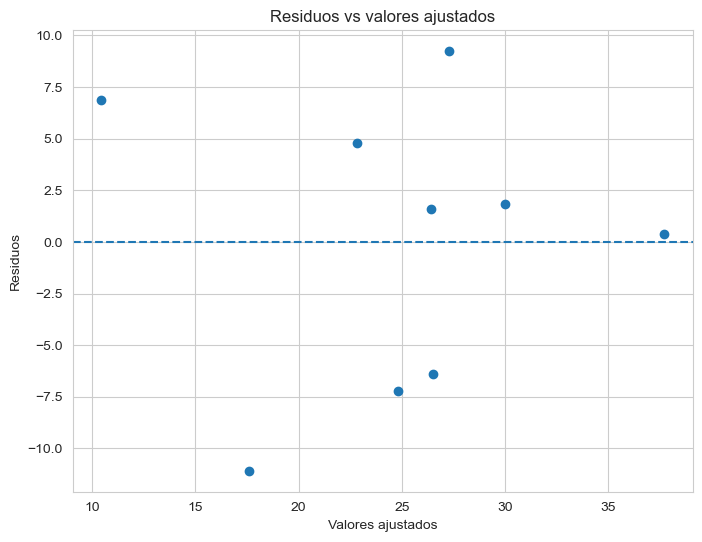

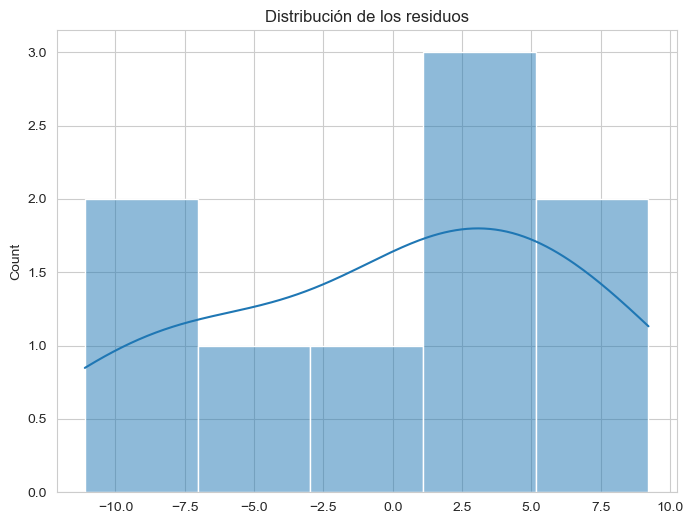

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot

sns.set_style("whitegrid")

# QQ Plot - Normalidad
plt.figure()
qqplot(modelo.resid, line='s')
plt.title("QQ Plot de los residuos")
plt.show()

# Residuos vs Ajustados - Homocedasticidad
plt.figure()
plt.scatter(modelo.fittedvalues, modelo.resid)
plt.axhline(0, linestyle='--')
plt.xlabel("Valores ajustados")
plt.ylabel("Residuos")
plt.title("Residuos vs valores ajustados")
plt.show()

# Histograma de residuos
plt.figure()
sns.histplot(modelo.resid, kde=True)
plt.title("Distribución de los residuos")
plt.show()


#### **3.5 Análisis gráfico de los supuestos**

- El **QQ Plot** permite evaluar visualmente la normalidad de los errores.
- El gráfico de **residuos vs valores ajustados** permite detectar posibles
  problemas de heterocedasticidad.
- El **histograma de residuos** muestra la forma general de la distribución
  de los errores del modelo.


#### **3.6 Verificación de los tipos de datos**

Antes de realizar la predicción, se verifica que todas las variables utilizadas
en el modelo tengan un tipo de dato numérico, ya que los modelos de regresión
lineal solo admiten variables cuantitativas.

In [ ]:
# =====================================================
# Tipos de datos de las variables del modelo
# =====================================================
print("Tipos de datos del DataFrame original:\n")
display(df_reg.dtypes)

print("\nTipos de datos del conjunto de predicción:\n")
display(nuevo_pais.dtypes)

Tipos de datos del DataFrame original:



Pobreza_Nacional    float64
Inflacion_Anual     float64
Indice_Gini         float64
PBI_Per_Capita      float64
dtype: object


Tipos de datos del conjunto de predicción:



const                int64
Inflacion_Anual    float64
Indice_Gini        float64
PBI_Per_Capita       int64
dtype: object

#### **3.7 Descripcion de los tipos de datos**

##### **Significado de las variables del modelo**

Antes de realizar la predicción, se describen las variables utilizadas en el
modelo de regresión lineal, con el fin de facilitar la comprensión de los
resultados obtenidos.

##### **Variables dependiente e independientes**

- **Pobreza_Nacional**:  
  Variable dependiente del modelo. Representa el porcentaje de la población
  que se encuentra en situación de pobreza a nivel nacional.

- **Inflacion_Anual**:  
  Variable explicativa que mide la variación porcentual anual de los precios
  de bienes y servicios. Una inflación elevada suele afectar negativamente el
  poder adquisitivo de la población.

- **Indice_Gini**:  
  Indicador de desigualdad económica que toma valores entre 0 y 1. Valores
  más altos indican mayor desigualdad en la distribución del ingreso.

- **PBI_Per_Capita**:  
  Producto Bruto Interno per cápita, expresado en dólares. Se obtiene al
  dividir el PBI total del país entre su población y representa una medida
  aproximada del nivel de ingresos promedio.


##### **Variable constante**

- **const**:  
  Representa el término constante del modelo de regresión. Permite capturar el
  nivel promedio de pobreza cuando todas las variables explicativas toman el
  valor cero.

#### **3.8 Predicción del modelo**

En esta sección se utiliza el modelo estimado para predecir el nivel de pobreza
nacional a partir de valores específicos de inflación, desigualdad (Índice de Gini)
y PBI per cápita.

In [ ]:
# =====================================================
# Predicción de la pobreza nacional
# =====================================================

nuevo_pais = pd.DataFrame({
    "const": [1],
    "Inflacion_Anual": [6.5],
    "Indice_Gini": [0.45],
    "PBI_Per_Capita": [12000]
})

prediccion = modelo.predict(nuevo_pais)
prediccion

0    2.064337
dtype: float64

Este valor representa el porcentaje estimado de la población que se
encontraría en situación de pobreza bajo las condiciones económicas
especificadas. Es decir, de cada 100 personas, alrededor de 2 personas
vivirían en situación de pobreza.